In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sys import exit
import pandas as pd
import glob
import pickle
from textwrap import wrap
import time
import math
import scipy
import itertools
from scipy import signal## because scipy doesn't always load its submodules for some reason
from scipy import stats
import scipy.integrate as integrate
from sklearn.metrics.cluster import adjusted_rand_score
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, pairwise_distances
from scipy.optimize import fsolve
import scipy.optimize
from scipy.stats import levy_stable
import sys
sys.path.append('/Users/ashish/Dropbox/research/James-research/city establishment data/')

import powerlaw
import shared_analysis_functions as shared_func
import importlib
importlib.reload(shared_func)
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance as scipy_spatial_distance

import warnings
fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# 
fontSize=12
fontSizeSmall=10
labelSize=8
sns.set(rc= {'figure.facecolor':'white'}) #'axes.facecolor':'cornflowerblue',

def create_color_list(scheme_name='sns_tab10',num_colors=6): 
    #https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    #https://seaborn.pydata.org/tutorial/color_palettes.html
    if scheme_name.lower()=='tableau':
        color_list=list(mcolors.TABLEAU_COLORS.values())## only had 10 colors
    elif scheme_name.lower()=='css':
        color_list=list(mcolors.CSS4_COLORS.values())
    elif scheme_name.lower()=='base':
        color_list=list(mcolors.BASE_COLORS.values())
    elif scheme_name.lower()=='sns_tab10':
        color_list=list(sns.color_palette(palette='tab10',n_colors=num_colors))
    elif scheme_name.lower()=='sns_deep':
        color_list=list(sns.color_palette(palette='deep',n_colors=num_colors))
    elif scheme_name.lower()=='sns_muted':
        color_list=list(sns.color_palette(palette='muted',n_colors=num_colors))
    elif scheme_name.lower()=='sns_colorblind':
        color_list=list(sns.color_palette(palette='colorblind',n_colors=num_colors))
    elif scheme_name.lower()=='sns_spectral':
        color_list=list(sns.color_palette(palette='Spectral',n_colors=num_colors))
    else:
        print ('scheme not implemented')
    if 'sns' not in scheme_name.lower():
        color_list=[color for color in color_list if sum(mcolors.to_rgb(color))<2.5] ## remove white
        mcolors.to_rgb(color_list[0])
    return  color_list
color_list_def=create_color_list()



In /Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /User

# define the time dependent pdf

In [ ]:
##mathematica definition
pdfXT[x_, t_, x0_, k_, tau_, Dtau_] := 
 PDF[GammaDistribution[k, Dtau], x]*
  Gamma[k]  * (((1/Dtau)^2    x0 x  Exp[-t/tau])^(1/2 - k/2) )/ (1 - 
     Exp[-t/tau])   *
  Exp[-( (1/Dtau) (x0 + x) Exp[-t/tau] )/(1 - Exp[-t/tau])]  * 
  BesselI[
   k - 1, ( (2/Dtau) Sqrt[x0 x  Exp[-t/tau]] )/(1 - Exp[-t/tau])]  

In [6]:
def time_dependent_pdf(x,t,x0,k,tau,Dtau):    
    return stats.gamma.pdf(x,k,scale=Dtau) *scipy.special.gamma(k)/ (1-np.exp(-t/tau))*np.power(
        np.square(1/Dtau) * x0 * x *np.exp(-t/tau) ,1./2 - k/2 )*np.exp(
        -( (1/Dtau)* (x0 + x)* np.exp(-t/tau) )/(1 - np.exp(-t/tau)) )*scipy.special.iv(
        k-1., ( (2/Dtau)*np.sqrt(x0*x*np.exp(-t/tau)) )/(1 - np.exp(-t/tau)))   

## test convergence to steady state gamma distribution

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


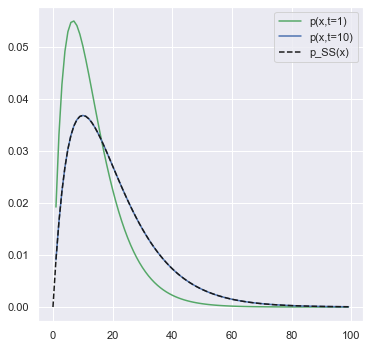

In [15]:


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)
# n_histbins, histbin_centers, mu,sigma,b_laplace,weibull_k,weibull_lambda,guess_params=get_plot_params(
#     log_N1,n_histbins=40)
# ax1.hist(log_N1,bins=n_histbins,density=True)


x0=2
t1=1
t2=10
tau=1
k=2
Dtau=10
xvalues=np.arange(0,100)
ax1.plot(xvalues,time_dependent_pdf(xvalues,t1,x0,k,tau,Dtau),
         'g-',label='p(x,t='+str(t1)+')' )

ax1.plot(xvalues,time_dependent_pdf(xvalues,t2,x0,k,tau,Dtau),
         'b-',label='p(x,t='+str(t2)+')' )
ax1.plot(xvalues,stats.gamma.pdf(xvalues,k,scale=Dtau),
         'k--',label='p_SS(x)')
ax1.legend(loc='best')

plt.tight_layout()
plt.show()

##### test numerical integration

In [19]:
x0=2
t1=1
t2=10
tau=1
k=2
Dtau=10
print('integrate between 0 and 10')
print(integrate.quad(lambda x: time_dependent_pdf(x,t1,x0,k,tau,Dtau), 0, 10)[0])
print ('integrate between 0 and 1000')
print(integrate.quad(lambda x: time_dependent_pdf(x,t1,x0,k,tau,Dtau), 0, 1000)[0])

integrate between 0 and 10
0.4400997907286801
integrate between 0 and 1000
1.0


## compute expected MSD
But this is the expected exponent if just computed cross-sectionally for one time point!

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


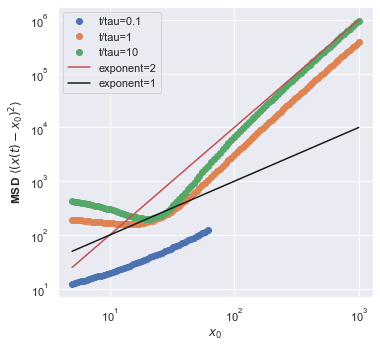

In [43]:
# x0=2
t1=.1
t2=1
t3=10
tau=1
k=2
Dtau=10


# x0values=np.arange(5,100)
x0values=np.logspace(np.log10(5),3,100)
MSD_list_t1=[]
MSD_list_t2=[]
MSD_list_t3=[]
for x0 in x0values:
    result=integrate.quad(lambda x: np.square(x-x0)*time_dependent_pdf(x,t1,x0,k,tau,Dtau), 
                          0, 2000)
    MSD_list_t1.append(result[0])
    result=integrate.quad(lambda x: np.square(x-x0)*time_dependent_pdf(x,t2,x0,k,tau,Dtau), 
                          0, 5000)
    MSD_list_t2.append(result[0])
    
    result=integrate.quad(lambda x: np.square(x-x0)*time_dependent_pdf(x,t3,x0,k,tau,Dtau), 
                          0, 5000)
    MSD_list_t3.append(result[0])
    
    
    

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)


ax1.plot(x0values,MSD_list_t1,'o',label='t/tau='+str(t1) )
ax1.plot(x0values,MSD_list_t2,'o',label='t/tau='+str(t2) )
ax1.plot(x0values,MSD_list_t3,'o',label='t/tau='+str(t3) )

ax1.plot(x0values,np.square(x0values),'r-',label=r'exponent=2' )
ax1.plot(x0values,10*x0values,'k-',label=r'exponent=1' )
# ax1.plot(xvalues,time_dependent_pdf(xvalues,t2,x0,k,tau,Dtau),
#          'b-',label='t/tau='+str(t2) )


ax1.legend(loc='best')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'$x_0$')
ax1.set_ylabel(r'MSD $\langle (x(t)-x_0)^2\rangle$')
plt.tight_layout()
plt.show()

In [25]:
np.arange(1,100)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [34]:
np.logspace(np.log10(5),2.5,100)

array([  5.        ,   5.21389435,   5.43693885,   5.66952495,
         5.91206082,   6.1649721 ,   6.42870263,   6.70371526,
         6.99049262,   7.28953799,   7.60137619,   7.92655447,
         8.26564351,   8.61923839,   8.98795967,   9.37245442,
         9.77339742,  10.19149232,  10.62747284,  11.08210411,
        11.55618399,  12.05054448,  12.56605315,  13.1036147 ,
        13.66417252,  14.24871037,  14.85825409,  15.4938734 ,
        16.15668379,  16.84784846,  17.56858037,  18.32014437,
        19.10385944,  19.92110095,  20.77330313,  21.66196155,
        22.58863577,  23.55495207,  24.56260629,  25.61336682,
        26.7090777 ,  27.85166185,  29.04312445,  30.28555648,
        31.58113835,  32.93214374,  34.34094362,  35.81001037,
        37.34192212,  38.93936734,  40.60514945,  42.34219184,
        44.15354293,  46.04238158,  48.01202261,  50.06592266,
        52.20768623,  54.44107202,  56.76999954,  59.19855594,
        61.73100323,  64.37178576,  67.12553798,  69.99

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


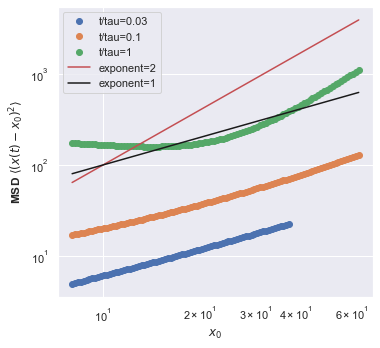

In [46]:
# x0=2
t1=.03
t2=.1
t3=1
tau=1
k=2
Dtau=10


# x0values=np.arange(5,100)
x0values=np.logspace(np.log10(8),1.8,100)
MSD_list_t1=[]
MSD_list_t2=[]
MSD_list_t3=[]
for x0 in x0values:
    result=integrate.quad(lambda x: np.square(x-x0)*time_dependent_pdf(x,t1,x0,k,tau,Dtau), 
                          0, 300)
    MSD_list_t1.append(result[0])
    result=integrate.quad(lambda x: np.square(x-x0)*time_dependent_pdf(x,t2,x0,k,tau,Dtau), 
                          0, 300)
    MSD_list_t2.append(result[0])
    
    result=integrate.quad(lambda x: np.square(x-x0)*time_dependent_pdf(x,t3,x0,k,tau,Dtau), 
                          0, 300)
    MSD_list_t3.append(result[0])
    
    
    

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)


ax1.plot(x0values,MSD_list_t1,'o',label='t/tau='+str(t1) )
ax1.plot(x0values,MSD_list_t2,'o',label='t/tau='+str(t2) )
ax1.plot(x0values,MSD_list_t3,'o',label='t/tau='+str(t3) )

ax1.plot(x0values,np.square(x0values),'r-',label=r'exponent=2' )
ax1.plot(x0values,10*x0values,'k-',label=r'exponent=1' )
# ax1.plot(xvalues,time_dependent_pdf(xvalues,t2,x0,k,tau,Dtau),
#          'b-',label='t/tau='+str(t2) )


ax1.legend(loc='best')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'$x_0$')
ax1.set_ylabel(r'MSD $\langle (x(t)-x_0)^2\rangle$')
plt.tight_layout()
plt.show()

# simulate model explicitly

In [8]:



def simulate_model(params):
    m=params['m']
    D=params['D']
    tau=params['tau']

    simulation_Time=params['simulation_Time']
    x0=params['x0']  
    x0=10
    dt=params['dt']
    Delta_t=params['Delta_t']
    
    x_time=[]
    time_list=[]
    ctr=0
    save_interval=Delta_t/dt
    x=x0
    for t in np.arange(0,simulation_Time,dt):


        if ctr % save_interval==0:
            x_time.append(x)
            time_list.append(t)

        x=x+ dt*(m - x/tau + np.random.normal()*D*np.sqrt(x)  )



        ctr+=1
    
    return  x_time,time_list 
    
    

In [11]:
params={}
params['m']=1.
params['D']=1
params['tau']=1
params['simulation_Time']=1000
params['x0'] =10
params['dt']=.01
params['Delta_t']=1


x_time,time_list =simulate_model(params)

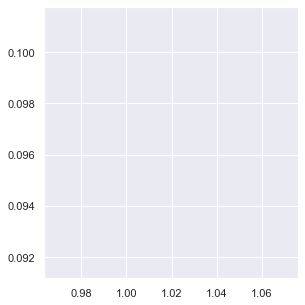

In [12]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(np.mean(x_time), np.var(x_time))


In [13]:
np.mean(x_time)

1.0198307625639822